# Project 2 INF265
## Object localization

# Content

     1. Data preparation and exploratory data analysis
          1.1 Loading data
          1.2 Visualization
          1.3 Data analysis
          1.4 Normalizing data
     2. Machine learning pipelines
          2.1 Architecture 1
          2.2 Architecture 2
     3. Training
          3.1 Finding the best model
               3.1.1 Loss function
               3.1.2 IoU performance function
               3.1.3 Training functions
          3.2 Checking model performances
     4. Visualization of results
          4.1 Visualization of predicted bounding boxes
     5. Report (own pdf file)

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from typing import Sequence
import math

torch.manual_seed(265)

# 1. Data preparation and exploratory data analysis

### 1.1 Loading data

In [2]:
train_data = torch.load('localization_train.pt')
val_data = torch.load('localization_val.pt')
test_data = torch.load('localization_test.pt')

In [3]:
# Extract one image and one label from the dataset
img, label = train_data[0]

print('Size of the dataset      : %d' %len(train_data))
print('Shape of the input       :', img.shape)
print('Type of the input        :', img.dtype)
print('Shape of the target      :', label.shape)
print('Type of the target       :', label.dtype)

Size of the dataset      : 59400
Shape of the input       : torch.Size([1, 48, 60])
Type of the input        : torch.float32
Shape of the target      : torch.Size([6])
Type of the target       : torch.float32


### 1.2 Visualizing data

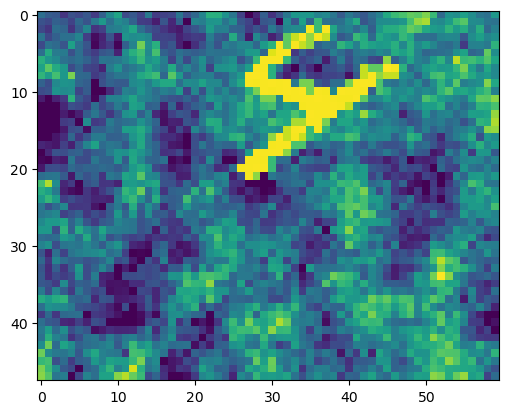

In [4]:
img1 = img[0]
plt.imshow(img1)
plt.show()

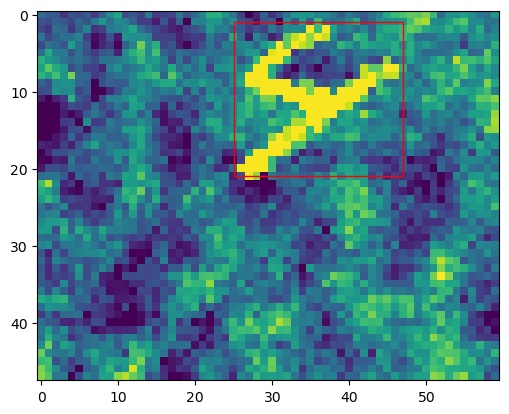

In [5]:
# Load the image from the tensorDataset
image, label = train_data[0]

# Convert the image tensor to a NumPy array and remove the channel dimension
image = np.squeeze(image.numpy())

# Extract the x, y, w, and h values from the label
_, x, y, w, h, _ = label

# Calculate the top left and bottom right coordinates of the bounding box
image_height, image_width = image.shape
left = (x - w / 2) * image_width
top = (y - h / 2) * image_height
right = left + w * image_width
bottom = top + h * image_height

# Create a Matplotlib figure and plot the image
fig, ax = plt.subplots()
ax.imshow(image)

# Create a Matplotlib rectangle object using the bounding box coordinates
rect = plt.Rectangle((left, top), right - left, bottom - top, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle object to the plot
ax.add_patch(rect)

# Show the plot
plt.show()


Label:  0


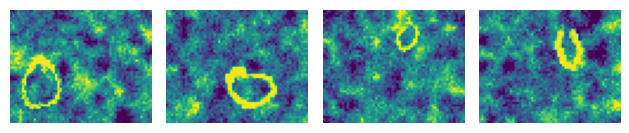

Label:  1


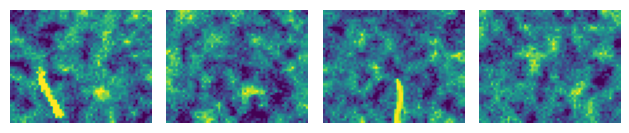

Label:  2


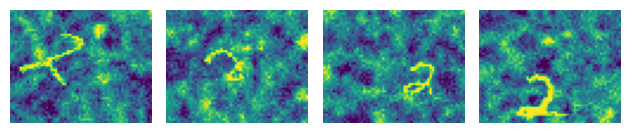

Label:  3


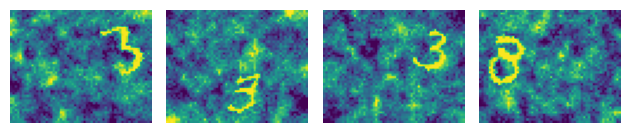

Label:  4


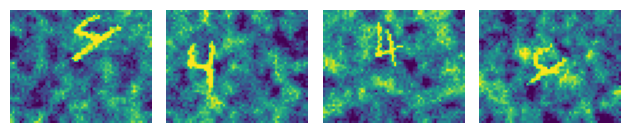

Label:  5


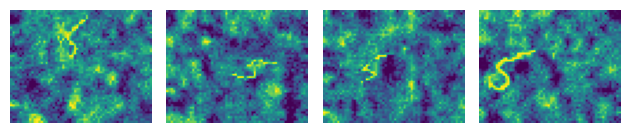

Label:  6


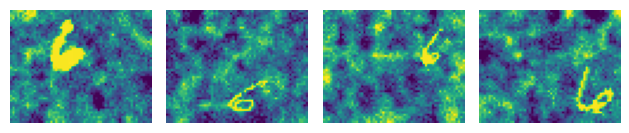

Label:  7


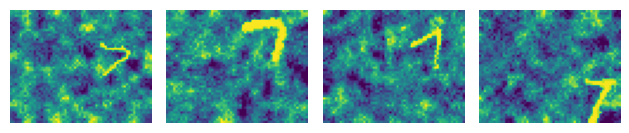

Label:  8


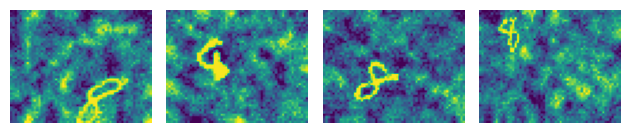

Label:  9


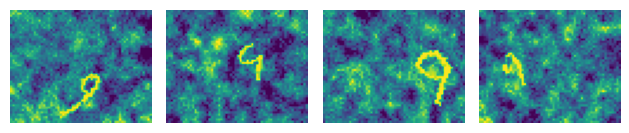

In [6]:
def plot_instances(data, label, n_instances=4):
    """
    Find and plot instances of the given class
    """
    fig, axes = plt.subplots(nrows=1, ncols=n_instances, tight_layout=True)
    # Find an image in the dataset with the right label
    print("Label: ", i)
    imgs = [img for (img, label) in train_data if label[-1] == i]
    for j, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(imgs[j].permute(1, 2, 0))
        # Remove ticks
        ax.axis('off')
    plt.show()
    return fig, axes

n_classes = len(Counter([int(label[-1]) for _, label in train_data]))
for i in range(n_classes):
    plot_instances(train_data, label, n_instances=4)

### 1.3 Data analysis


 ------- training dataset ------- 
Mean:  0.41708362102508545
Std:   0.2138432264328003
Min:   0.0
Max:   1.0

Number of classes:               10
Biggest class:   1   occurrence:  11475
Smallest class:  5   occurrence:  4889


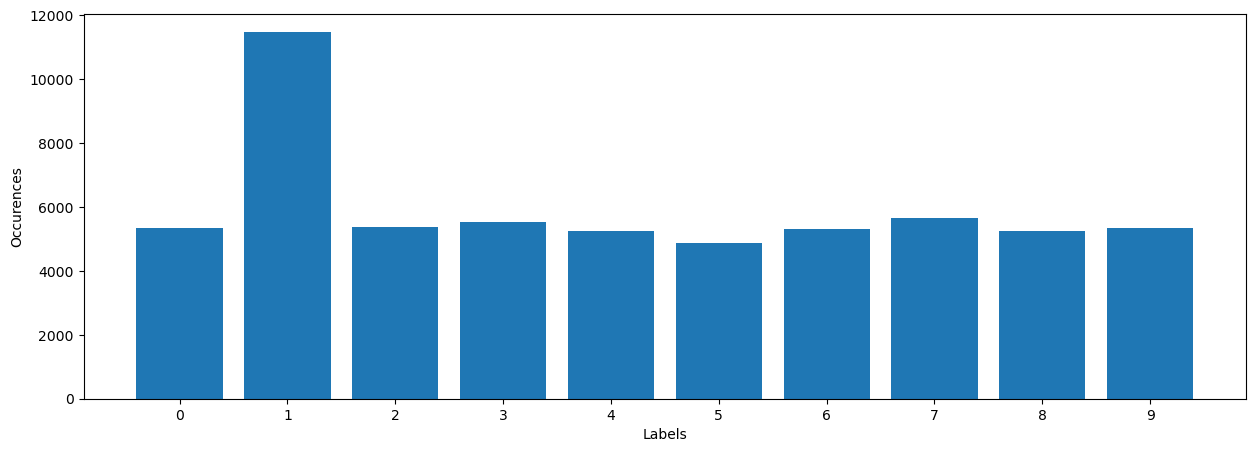


 ------- validation dataset ------- 
Mean:  0.4169342517852783
Std:   0.21374431252479553
Min:   0.0
Max:   1.0

Number of classes:               10
Biggest class:   1   occurrence:  1267
Smallest class:  5   occurrence:  532


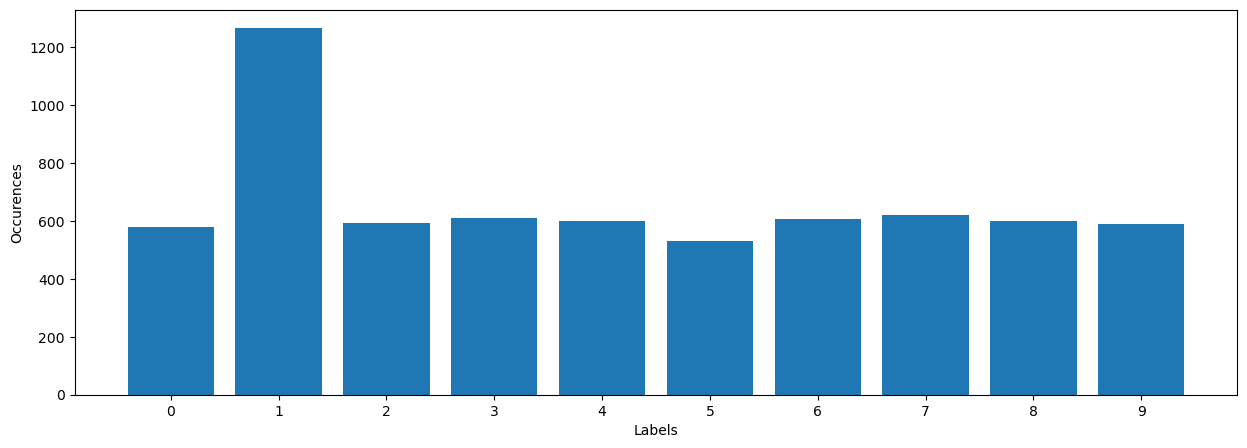


 ------- test dataset ------- 
Mean:  0.41719967126846313
Std:   0.21442833542823792
Min:   0.0
Max:   1.0

Number of classes:               10
Biggest class:   1   occurrence:  2135
Smallest class:  5   occurrence:  892


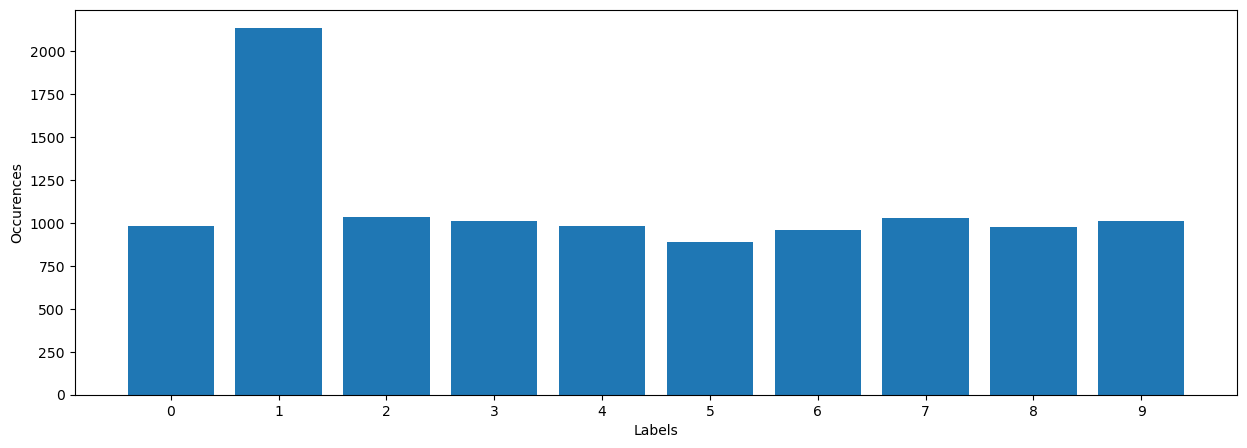

In [7]:
def compute_statistics(data):
    """
    Helper function to compute basic statistics in the 'analyse_dataset' 
    function
    """
    imgs = torch.cat([img for img, _ in data])
    mean = torch.mean(imgs).item()
    std = torch.std(imgs).item()
    amin = torch.min(imgs).item()
    amax = torch.max(imgs).item()
    print("Mean: ", mean)
    print("Std:  ", std)
    print("Min:  ", amin)
    print("Max:  ", amax)

def plot_histogram(counter):
    """
    Helper function to plot histogram of the number of instances in each 
    class in the 'analyse_dataset' function
    """
    # Convert to list of tuple (label, occurrences) sorted in decreasing order
    c = counter.most_common()
    n_classes = len(counter)
    
    labels = np.arange(n_classes)
    labels = [x[0] for x in c]
    occurrences = [counter[l] for l in labels]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(labels, occurrences, tick_label=labels)
    ax.set_ylabel("Occurences")
    ax.set_xlabel("Labels")
    return fig, ax


def analyse_dataset(data):
    """
    Examples of basic analysis that one can perform on an unknown dataset.
    
    - Compute basic statistics
    - Find number of classes
    - Check occurences of each label in the dataset
    - Plot histogram
    """
    compute_statistics(data)
        
    # Count occurences
    counter = Counter([int(label[-1]) for _, label in data])
    
    # Total number of datapoints in the dataset
    n_tot = counter.total()
    
    # Total number of classes in the dataset
    n_classes = len(counter)
    
    # Convert to list of tuple (label, occurrences) sorted in decreasing order
    c = counter.most_common()
    
    print('\nNumber of classes:               %d' %len(c))
    print("Biggest class:   %d   occurrence:  %d" %(c[0][0], c[0][1]))
    print("Smallest class:  %d   occurrence:  %d" %(c[-1][0], c[-1][1]))
    
    
    fig, ax = plot_histogram(counter)
    plt.show()
    return counter

print("\n ------- training dataset ------- ")
counter_train = analyse_dataset(train_data)
print("\n ------- validation dataset ------- ")
counter_val = analyse_dataset(val_data)
print("\n ------- test dataset ------- ")
counter_test = analyse_dataset(test_data)

n_classes = len(counter_train)

### 1.4 Normalizing data

In [8]:
data = [x for x, _ in train_data]
stacked = torch.stack(data)
train_data.transform = transforms.Normalize(stacked.mean(), stacked.std())

In [9]:
# Helper function convert single int value to pair when entering values to MyNet()
def int_to_pair(n):
    """
    Return `(n, n)` if `n` is an int or `n` if it is already a tuple of length 2
    """
    # If n is a float or integer
    if not isinstance(n, Sequence):
        return (int(n), int(n))
    elif len(n) == 1:
        return (int(n[0]), int(n[0]))
    elif len(n) == 2:
        return ( int(n[0]), int(n[1]) )
    else:
        raise ValueError("Please give an int or a pair of int")

# 2. Machine learning pipelines

### 2.1 Architecture 1

In [10]:
# Just to prepare single image so i can test the below models
img1 = img.unsqueeze(0)

In [11]:
# YOLO

class MyNet(nn.Module):
    def __init__(
        self, 
        kernel_size: Sequence = (3, 3), 
        stride: Sequence = (1, 1), 
        padding:Sequence = (1, 1), 
        bias: bool = True
        ):
        
        super().__init__() 
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2)
        # Fully connected layers
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=15)

    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        # Layer 2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        # Layer 3
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        # Layer 4
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.pool4(out)
        # Layer 5
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.pool5(out)
        # Flatten before fully connected layer
        out = self.flat(out)
        # FC 1
        out = self.fc1(out)
        out = self.relu6(out)
        # FC 2
        out = self.fc2(out)
        return out
    
model = MyNet()
out = model(img1)

#### Visualizing a single bounding box created from model 1

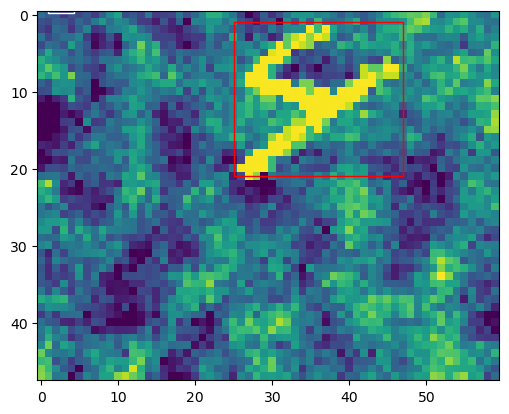

In [12]:
# Load the image from the tensorDataset
image, label = train_data[0]

# Convert the image tensor to a NumPy array and remove the channel dimension
image = np.squeeze(image.detach().numpy())

# Extract the x, y, w, and h values from the label
x, y, w, h = out[0][1:5].detach().numpy()
x_pred, y_pred, w_pred, h_pred = label[1:5]

# Calculate the top left and bottom right coordinates of the bounding box
image_height, image_width = image.shape
left = (x - w / 2) * image_width
top = (y - h / 2) * image_height
right = left + w * image_width
bottom = top + h * image_height

# Calculate the top left and bottom right coordinates of the bounding box
label_height, label_width = image.shape
left_pred = (x_pred - w_pred / 2) * label_width
top_pred = (y_pred - h_pred / 2) * label_height
right_pred = left_pred + w_pred * label_width
bottom_pred = top_pred + h_pred * label_height

# Create a Matplotlib figure and plot the image
fig, ax = plt.subplots()
ax.imshow(image)

# Create a Matplotlib rectangle object using the bounding box coordinates
rect_pred = plt.Rectangle((left, top), right - left, bottom - top, linewidth=1, edgecolor='w', facecolor='none')
rect_true = plt.Rectangle((left_pred, top_pred), 
                          right_pred - left_pred, bottom_pred - top_pred, 
                          linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle object to the plot
ax.add_patch(rect_pred)
ax.add_patch(rect_true)

# Show the plot
plt.show()

### 2.2 Architecture 2

In [13]:
class MyNet2(nn.Module):
    def __init__(
        self, 
        kernel_size: Sequence = (3, 3), 
        stride: Sequence = (1, 1), 
        padding:Sequence = (0, 0), 
        bias: bool = True
        ):
        
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=kernel_size, stride=stride, padding=2, bias=bias)  
        self.relu1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=2464, out_features=512)
        self.relu3 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=512, out_features=120)
        self.relu4 = nn.Tanh()
        self.fc3 = nn.Linear(in_features=120, out_features=15)

    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        # Layer 2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        # FLatten
        out = self.flat(out)
        # FC 1
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        # FC 2
        out = self.relu4(out)
        # FC 3
        out = self.fc3(out)
        return out
    

model2 = MyNet2()
out = model2(img1)

# Architecture 3

In [14]:
# Version of VGG16

class MyNet3(nn.Module):
    def __init__(
        self, 
        kernel_size: Sequence = (3, 3), 
        stride: Sequence = (1, 1), 
        padding:Sequence = (0, 0), 
        bias: bool = True
        ):
        
        super().__init__() 
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size, stride=stride, padding=2, bias=bias)  
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=kernel_size, stride=stride, padding=2, bias=bias)  
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 2
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, stride=stride, padding=2, bias=bias)  
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Layer 3
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, stride=stride, padding=2, bias=bias)  
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten
        self.flat = nn.Flatten()
        # FC 1
        self.fc1 = nn.Linear(in_features=3072, out_features=512)
        self.relu7 = nn.ReLU()
        # FC 2
        self.fc2 = nn.Linear(in_features=512, out_features=120)
        self.relu8 = nn.ReLU()
        # FC 3
        self.fc3 = nn.Linear(in_features=120, out_features=15)

    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool1(out)
        # Layer 2
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.pool2(out)
        # Layer 3
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out = self.pool3(out)
        
        # FLatten
        out = self.flat(out)
        # FC 1
        out = self.fc1(out)
        out = self.relu7(out)
        # FC 2
        out = self.fc2(out)
        out = self.relu8(out)
        # FC 3
        out = self.fc3(out)
        return out
    

model2 = MyNet3()
out = model2(img1)

# 3 Training

### 3.1 Finding the best model

#### 3.1.1 Loss function

In [15]:
def custom_loss(outputs, labels):
    detection_loss = F.binary_cross_entropy_with_logits(outputs[:, 0], labels[:,0])
    mask = (labels[:, 0] == 1)
    object_pred = outputs[mask]
    object_label = labels[mask]
    
    localization_loss = F.mse_loss(object_pred[:, 1:5], object_label[:, 1:5])
    classification_loss = F.cross_entropy(object_pred[:, 5:], object_label[:, 5].long())
    
    total_loss = detection_loss + localization_loss + classification_loss
    return total_loss

#### 3.1.2 IoU Performance function

In [16]:
def calculate_iou(predicted_box, target_box):
    
	x1, y1, w1, h1 = predicted_box[:,0], predicted_box[:,1], predicted_box[:,2], predicted_box[:,3]
	x2, y2, w2, h2 = target_box[:,0], target_box[:,1], target_box[:,2], target_box[:,3]

	xmin1, ymin1 = x1 - w1 / 2, y1 - h1/2
	xmax1, ymax1 = x1 + w1 / 2, y1 + h1/2
	xmin2, ymin2 = x2 - w2 / 2, y2 - h2/2
	xmax2, ymax2 = x2 + w2 / 2, y2 + h2/2

	# determine the (x, y)-coordinates of the intersection rectangle
	xmin_inter = torch.max(xmin1, xmin2)
	ymin_inter = torch.max(ymin1, ymin2)
	xmax_inter = torch.min(xmax1, xmax2)
	ymax_inter = torch.min(ymax1, ymax2)

	# compute the area of intersection rectangle
	intersection_area = torch.clamp(xmax_inter - xmin_inter, min=0) * torch.clamp(ymax_inter - ymin_inter, min=0)

	# compute the area of both the prediction and ground-truth
	# rectangles
	union_area = w1 * h1 + w2 * h2 - intersection_area
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = intersection_area / union_area.clamp(min=1e-6)  # Clamp to avoid division by zero
	iou[union_area <= 0] = 0  # Set IOU to 0 where union area is 0 to avoid NaN
	# return the intersection over union value
	return iou


#### 3.1.3 Train functions

In [17]:
device = torch.device('cpu')

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    optimizer.zero_grad(set_to_none=True)
    
    weight_values = []
    bias_values = []
    
    for epoch in range(1, n_epochs + 1):
        
        # Train model and compute training loss
        model.train()
        loss_train = 0.0
        
        for imgs, labels in train_loader:

            # We use torch.double to get the same results as Pytorch
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
                                             
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    return weight_values, bias_values, losses_train

In [18]:
def train_all(
    models, optimizers, loss_functions, data_train,
    n_epochs, batch_size
):
    """
    Train a list of models and return the train and validation losses
    for each model
    """
    
    losses_train = []
    
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        
        model.to(device=device)
        
        # All models with share *exactly* the same dataloaders (same shuffle)
        torch.manual_seed(265)
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

        # Regular training loop for one model
        loss_train = train(
            n_epochs = n_epochs,
            optimizer = optimizer,
            model = model,
            loss_fn = loss_functions,
            train_loader = train_loader,
        )[2]

        losses_train.append(loss_train)
    return losses_train

In [19]:
n_epochs = 30
batch_size = 64

models = []
optimizers = []

# ----------  MyNet() with diffenrent optimizers ----------

#model = MyNet3()
#models.append(model)
#optimizers.append(optim.SGD(model.parameters(), lr=1e-3))

model = MyNet3()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-3, momentum=0.9))

model = MyNet3()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-2, momentum=0.9))

#model = MyNet3()
#models.append(model)
#optimizers.append(optim.Adam(model.parameters(), lr=1e-2))



# ---------- MyNet2() with diffenrent optimizers ----------

#model = MyNet2()
#models.append(model)
#optimizers.append(optim.SGD(model.parameters(), lr=1e-3))

#model = MyNet2()
#models.append(model)
#optimizers.append(optim.SGD(model.parameters(), lr=1e-3, momentum=0.9))

model = MyNet2()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-2, momentum=0.9))

#model = MyNet2()
#models.append(model)
#optimizers.append(optim.Adam(model.parameters(), lr=1e-2))


# ---------- MyNet3() with diffenrent optimizers ----------

model = MyNet()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-3))

model = MyNet()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-3, momentum=0.9))

model = MyNet()
models.append(model)
optimizers.append(optim.SGD(model.parameters(), lr=1e-2, momentum=0.9))

model = MyNet()
models.append(model)
optimizers.append(optim.Adam(model.parameters(), lr=1e-2))

In [20]:
losses_train = train_all(
    models, optimizers, custom_loss, train_data,
    n_epochs, batch_size,
)
print(losses_train)

10:05:00.191009  |  Epoch 1  |  Training loss 2.70501
10:09:43.266402  |  Epoch 2  |  Training loss 2.62598
10:14:07.482824  |  Epoch 3  |  Training loss 2.62541
10:18:28.067053  |  Epoch 4  |  Training loss 2.62441
10:22:51.998642  |  Epoch 5  |  Training loss 2.62161
10:27:13.818253  |  Epoch 6  |  Training loss 2.60919
10:31:36.221831  |  Epoch 7  |  Training loss 2.49868
10:35:59.494514  |  Epoch 8  |  Training loss 2.34611
10:40:22.607942  |  Epoch 9  |  Training loss 2.18794
10:44:44.624389  |  Epoch 10  |  Training loss 2.04484
10:49:04.944410  |  Epoch 11  |  Training loss 1.94472
10:53:33.805046  |  Epoch 12  |  Training loss 1.81992
10:57:53.334453  |  Epoch 13  |  Training loss 1.71610
11:02:11.455938  |  Epoch 14  |  Training loss 1.61480
11:06:30.770164  |  Epoch 15  |  Training loss 1.47879
11:10:48.789806  |  Epoch 16  |  Training loss 1.35792
11:15:06.443933  |  Epoch 17  |  Training loss 1.26909
11:19:24.784754  |  Epoch 18  |  Training loss 1.17412
11:23:43.470201  | 

IndexError: list index out of range

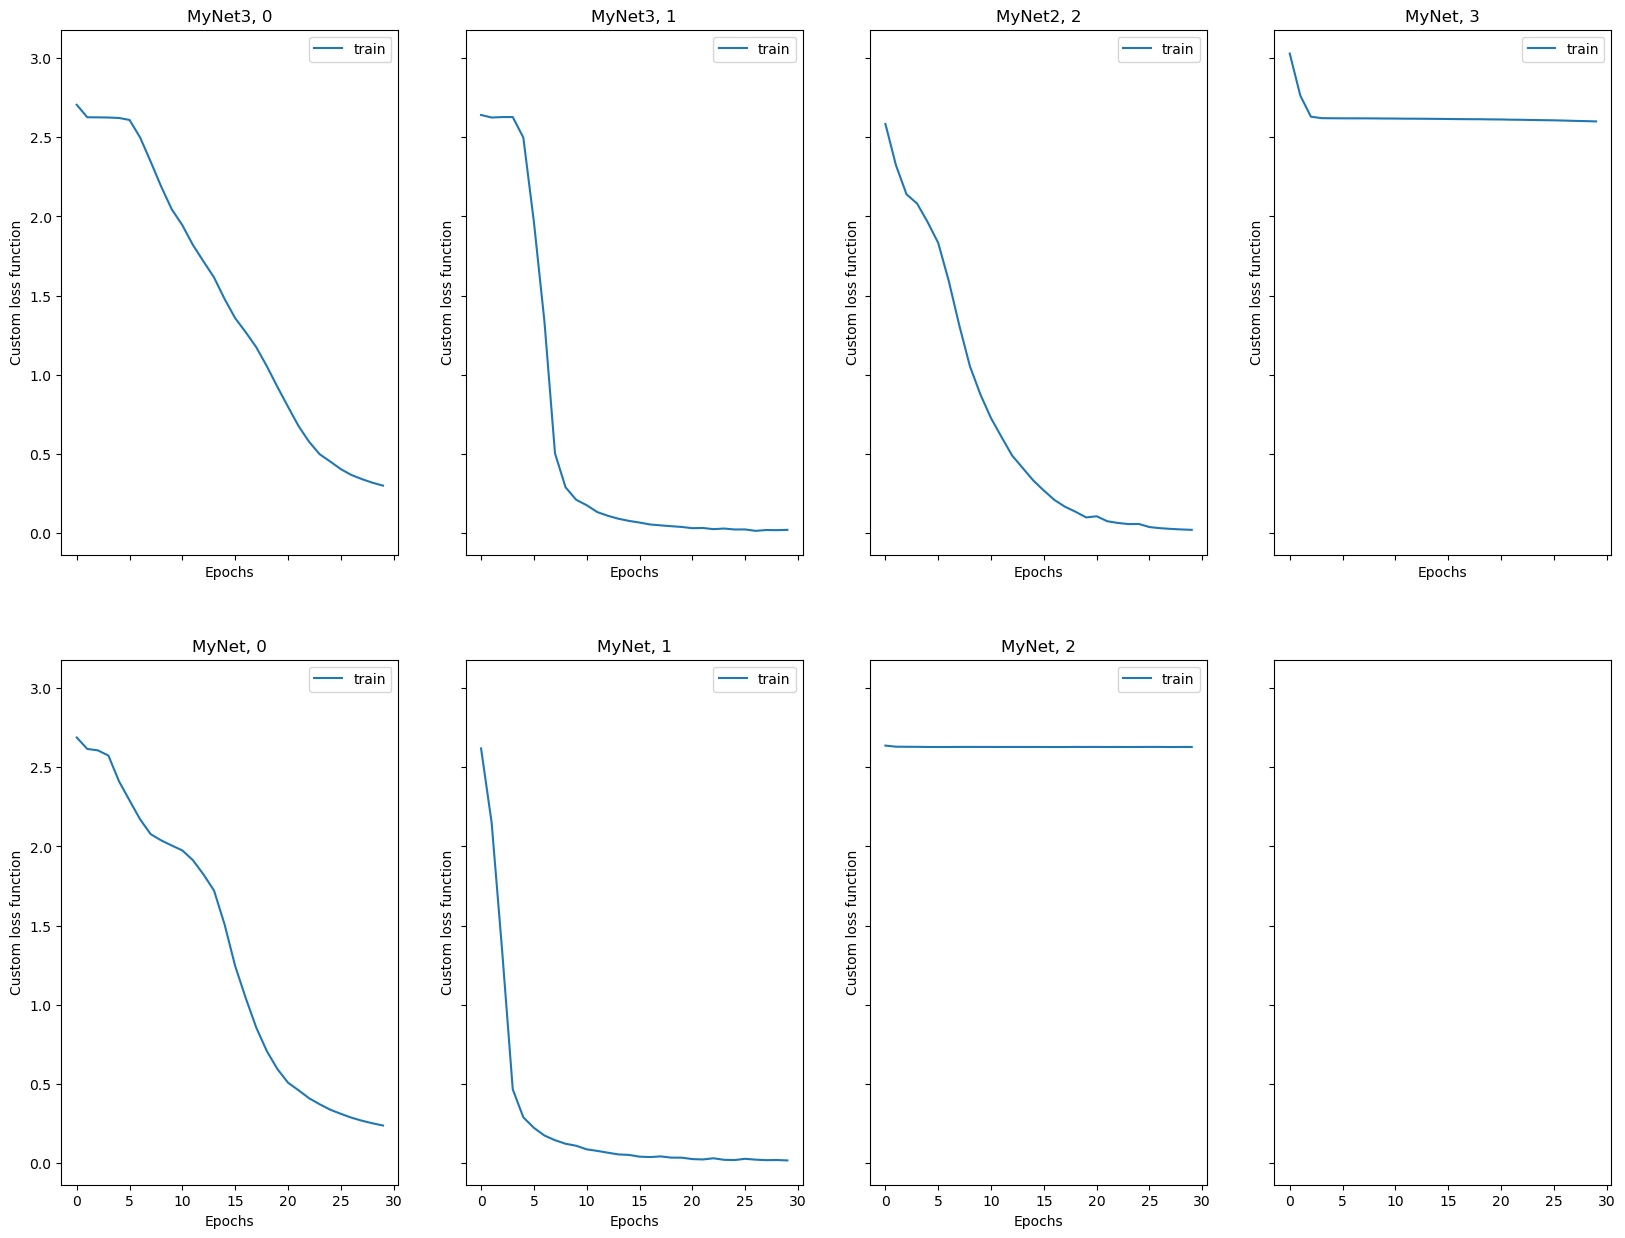

In [21]:
n_model = len(models)
fig, axes = plt.subplots(2, 4, figsize=(20, 15), sharey=True, sharex=True)

# Plot the evolution of the training and validation losses for each model
for i, ax in enumerate(axes.flat):

    name = models[i].__class__.__name__ + ", " + str(i % 4)
    ax.plot(losses_train[i], label='train')
    #ax.plot(losses_val[i], label='validation')
    ax.set_title(name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Custom loss function')
    ax.legend()

plt.show()

### 3.2 Checking model performances

In [22]:
# Here we use shuffle = False
# Because it is easier to check the predictions made.
torch.manual_seed(265)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

def compute_performance(model, loader):
    model.eval()
    correct_classification = 0
    correct_class_classification = 0
    average_IoU = np.array([])
    total = 0
    total_class = 0

    # We do not want gradients here, as we will not want to update the parameters.
    with torch.no_grad():
        for imgs, labels in loader:
            
            outputs = model(imgs)
            predicted_class = torch.sigmoid(outputs[:,0])

            # Accuracy for object classification
            total += labels.shape[0]
            correct_classification += torch.sum((predicted_class > 0.5) == labels[:,0].bool())
            
            # Accuracy for object localization IoU
            pred_iou, label_iou = outputs[:, 1:5], labels[:,1:5]
            average_IoU = np.append(average_IoU, calculate_iou(pred_iou, label_iou))
            
            # Accuracy for object detection
            total_class += labels.shape[0]
            predicted_object = torch.argmax(outputs[:, 5:-1], dim=1)
            correct_class_classification += torch.sum(predicted_object == labels[:, 5])

    acc_classification =  correct_classification / total
    avg_IoU = np.mean(average_IoU)
    acc_object_pred = correct_class_classification / total_class
    return acc_classification, avg_IoU, acc_object_pred

In [23]:
def model_selection(models, data_train, data_val):
    """
    Select the best model based on the validation performance
    """
    batch_size = 64

    perf_train_acc = []
    perf_train_iou = []
    perf_val_acc = []
    perf_val_iou = []
    perf_train_object = []
    perf_val_object = []
    
    # Compute all training and validation performance
    for i, model in enumerate(models):
        print(" ============= model %d ============= " %i)
        
        model.to(device=device)
        torch.manual_seed(265)
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)
        
        acc = compute_performance(model, train_loader)

        perf_train_acc.append(acc[0].item())
        perf_train_iou.append(acc[1])
        perf_train_object.append(acc[2].item())
        print("Training Accuracy:     %.4f" %acc[0].item())
        print("Training IoU:     %.4f" %acc[1])
        print("Training class prediction:   %.4f" %acc[2].item())
        print()
        acc = compute_performance(model, val_loader)
        perf_val_acc.append(acc[0].item())
        perf_val_iou.append(acc[1])
        perf_val_object.append(acc[2].item())
        print("Validation Accuracy:   %.4f" %acc[0].item())
        print("Validation IoU:   %.4f" %acc[1])
        print("Validation class prediction:   %.4f" %acc[2].item())
        
    # Select the best model based on the validation performance
    i_best_model = np.argmax(perf_val_iou)
    return perf_train_acc, perf_train_iou, perf_train_object, perf_val_acc, perf_val_iou, perf_val_object, i_best_model

In [24]:
perf_train_acc, perf_train_iou, perf_train_object, perf_val_acc, perf_val_iou, perf_val_object, i_best_model = model_selection(models, train_data, val_data)

best_model = models[i_best_model]
print("\nThe best model is: ")
print(" ----------------------------------------- ")
print(" Model:           ", models[i_best_model])
print(" Optimizer:       ", optimizers[i_best_model])
print(" ----------------------------------------- ")
print("\n Performance:   ")
print(" ----------------------------------------- ")
print(' Training accuracy:        %.4f' %perf_train_acc[i_best_model])
print(' Training IoU:        %.4f' %perf_train_iou[i_best_model])
print(' Training class pred:        %.4f' %perf_train_object[i_best_model])
print(' Validation accuracy:      %.4f' %perf_val_acc[i_best_model])
print(' Validation IoU:        %.4f' %perf_train_iou[i_best_model])
print(' Validation class pred:        %.4f' %perf_train_object[i_best_model])
print(" ----------------------------------------- ")

 ============= model 0 ============= 
Training Accuracy:     0.9994
Training IoU:     0.5145
Training class prediction:   0.8468

Validation Accuracy:   0.9994
Validation IoU:   0.5124
Validation class prediction:   0.8295
 ============= model 1 ============= 
Training Accuracy:     0.9999
Training IoU:     0.5533
Training class prediction:   0.9020

Validation Accuracy:   0.9995
Validation IoU:   0.5487
Validation class prediction:   0.8715
 ============= model 2 ============= 
Training Accuracy:     1.0000
Training IoU:     0.5304
Training class prediction:   0.9075

Validation Accuracy:   0.9974
Validation IoU:   0.5263
Validation class prediction:   0.7720
 ============= model 3 ============= 
Training Accuracy:     0.9091
Training IoU:     0.1951
Training class prediction:   0.1936

Validation Accuracy:   0.9091
Validation IoU:   0.1957
Validation class prediction:   0.1920
 ============= model 4 ============= 
Training Accuracy:     0.9991
Training IoU:     0.5125
Training class 

#### Running the fifth (best model) again.

        To check it against the test data

In [27]:
torch.manual_seed(265)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True) 
    

model = MyNet3()


optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


loss_fn = custom_loss


train(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
print('')

11:12:27.017381  |  Epoch 1  |  Training loss 2.62796
11:16:52.793323  |  Epoch 2  |  Training loss 2.16818
11:21:25.262020  |  Epoch 3  |  Training loss 1.67460
11:25:44.704851  |  Epoch 4  |  Training loss 0.83364
11:29:56.089691  |  Epoch 5  |  Training loss 0.37646
11:34:13.249509  |  Epoch 6  |  Training loss 0.25332
11:38:37.565616  |  Epoch 7  |  Training loss 0.18941
11:43:03.107733  |  Epoch 8  |  Training loss 0.14559
11:47:22.170371  |  Epoch 9  |  Training loss 0.12206
11:51:30.474578  |  Epoch 10  |  Training loss 0.09701
11:55:47.812192  |  Epoch 11  |  Training loss 0.08203
12:00:04.058624  |  Epoch 12  |  Training loss 0.06581
12:04:16.160335  |  Epoch 13  |  Training loss 0.05545
12:08:32.199903  |  Epoch 14  |  Training loss 0.04896
12:12:49.701884  |  Epoch 15  |  Training loss 0.04657
12:16:59.265898  |  Epoch 16  |  Training loss 0.03770
12:21:01.381043  |  Epoch 17  |  Training loss 0.03657
12:25:02.445822  |  Epoch 18  |  Training loss 0.03265
12:29:10.809964  | 

In [28]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

test_acc = compute_performance(best_model, test_loader)
print("Test performance of the best model (accuracy):    %.4f" %test_acc[0])
print("Test performance of the best model (IoU):    %.4f" %test_acc[1])
print("Test performance of the best model (Class prediction accuracy):    %.4f" %test_acc[2])

Test performance of the best model (accuracy):    0.9991
Test performance of the best model (IoU):    0.5528
Test performance of the best model (Class prediction accuracy):    0.8694


# 4 Visualizing bounding box predictions

### 4.1 Visualization of predicted bounding boxes

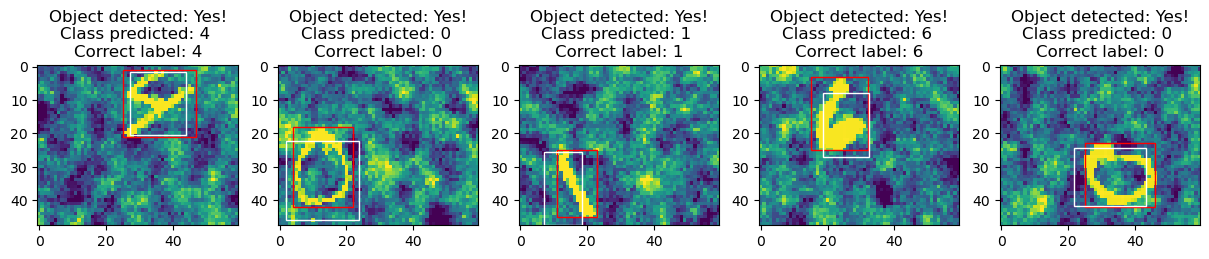

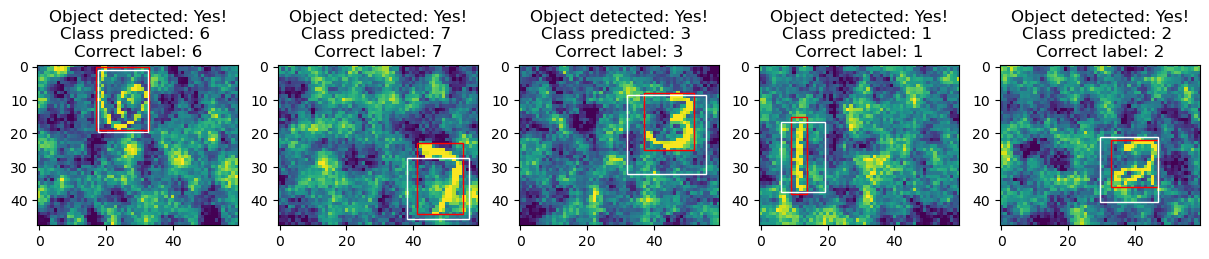

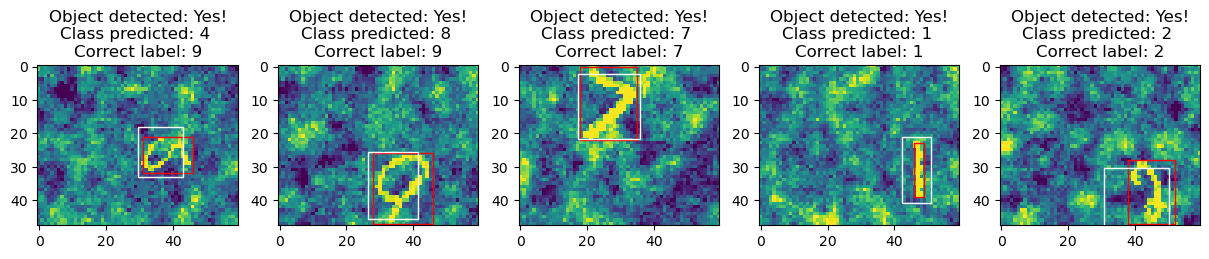

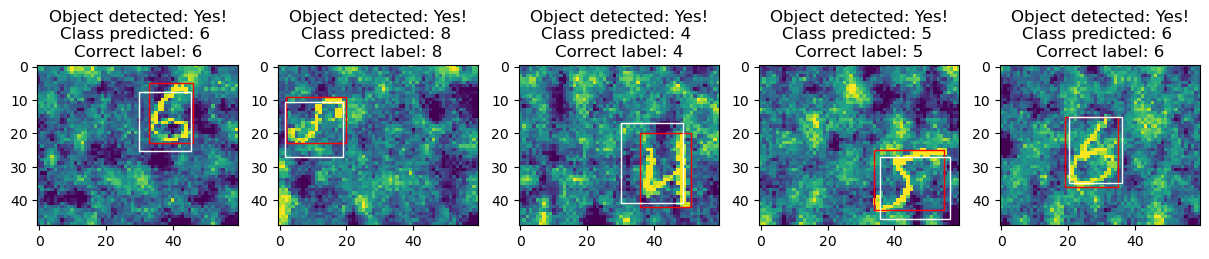

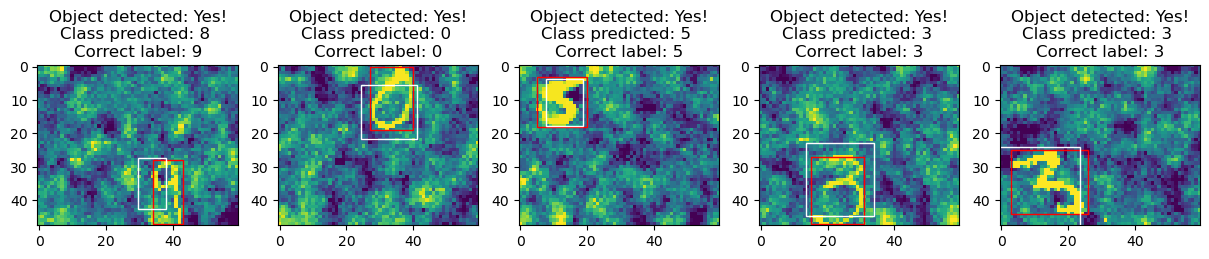

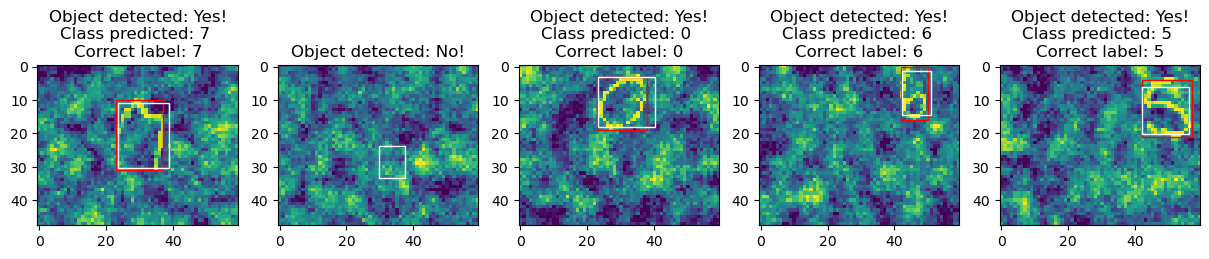

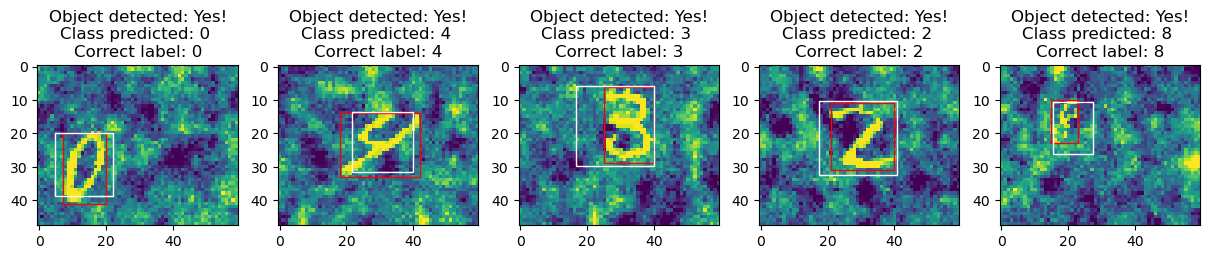

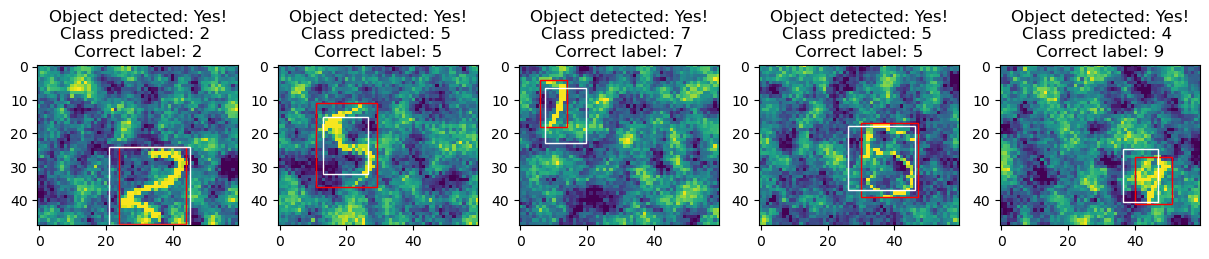

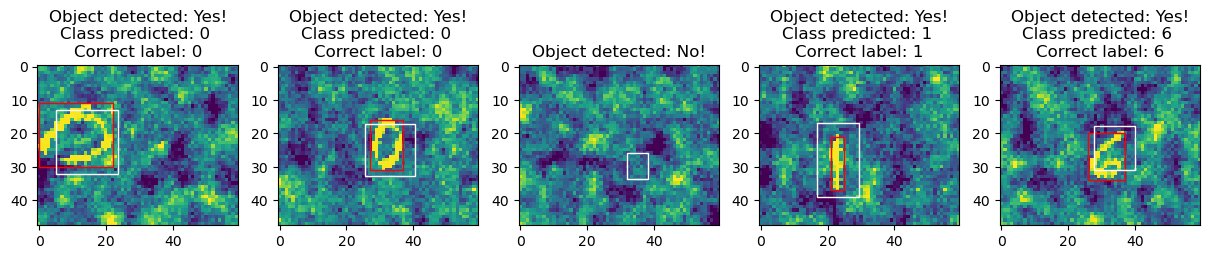

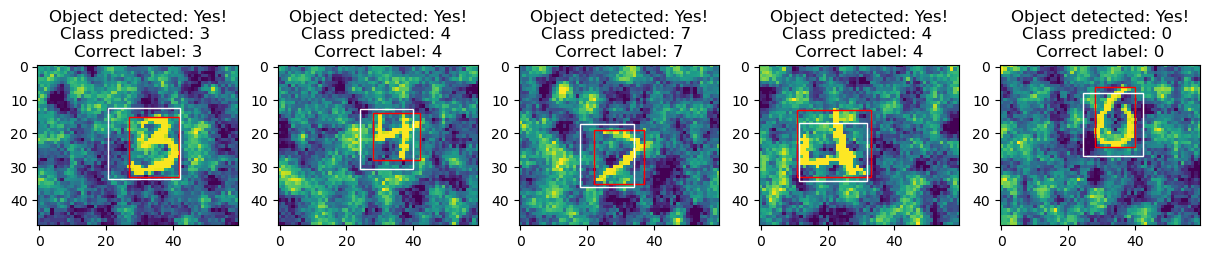

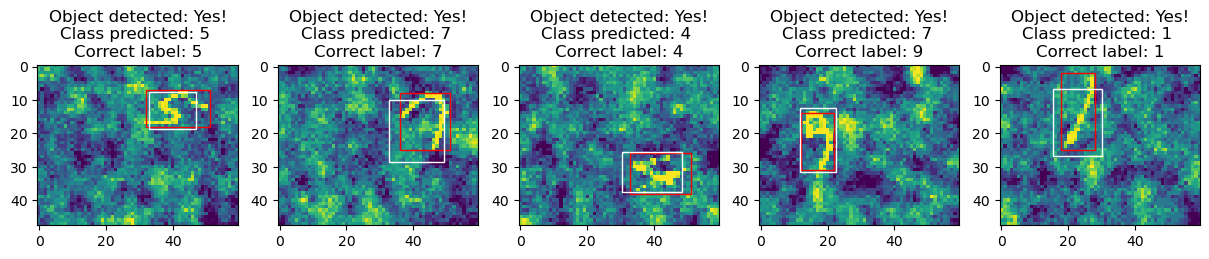

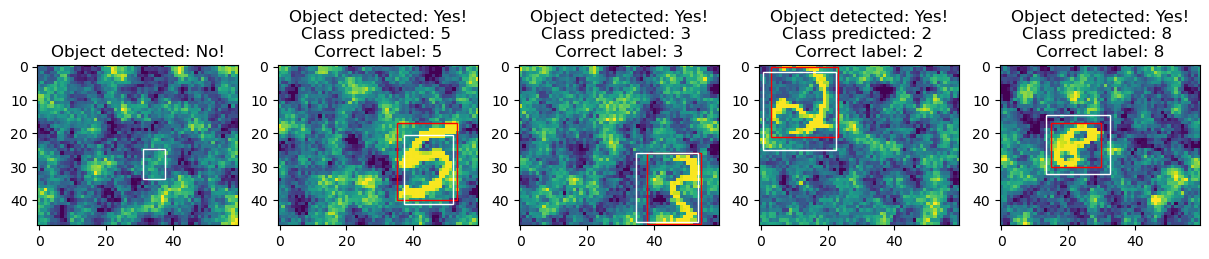

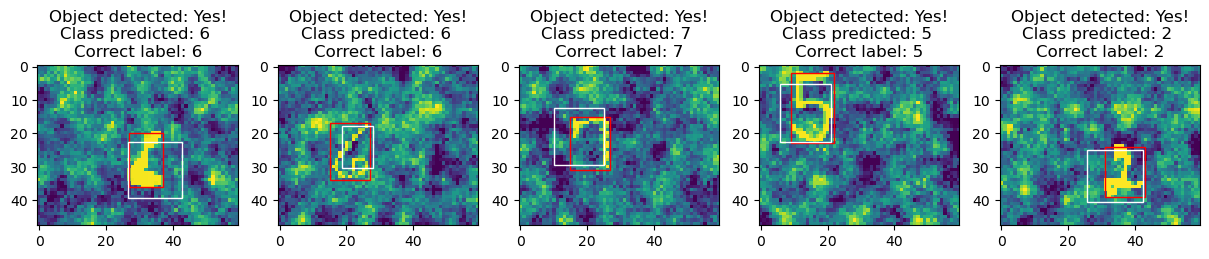

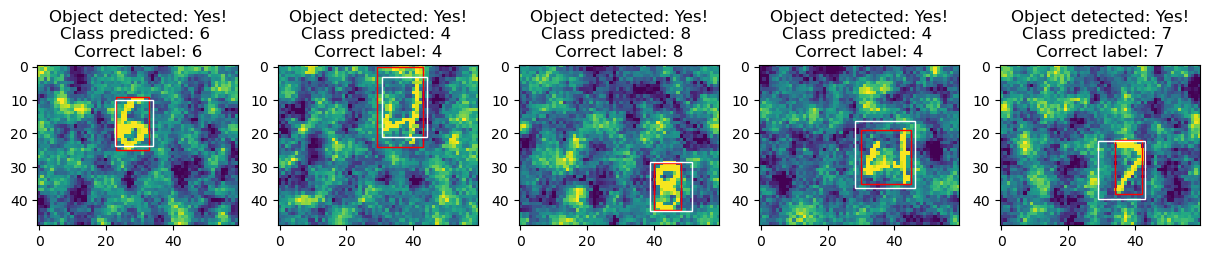

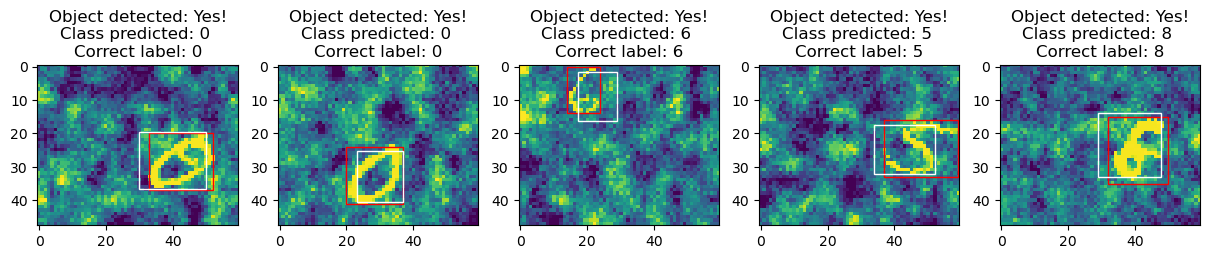

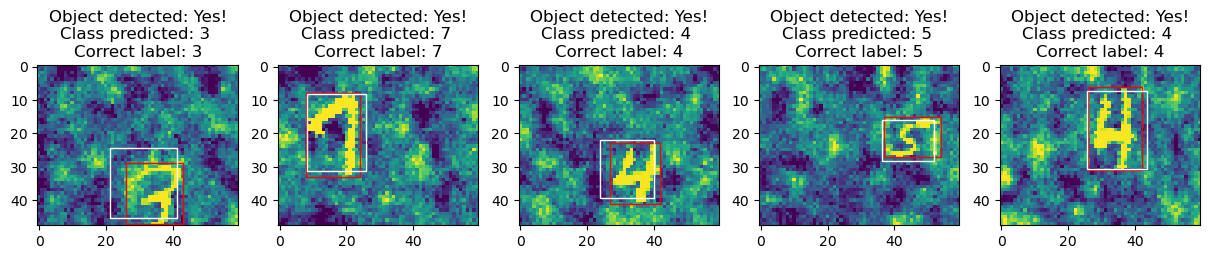

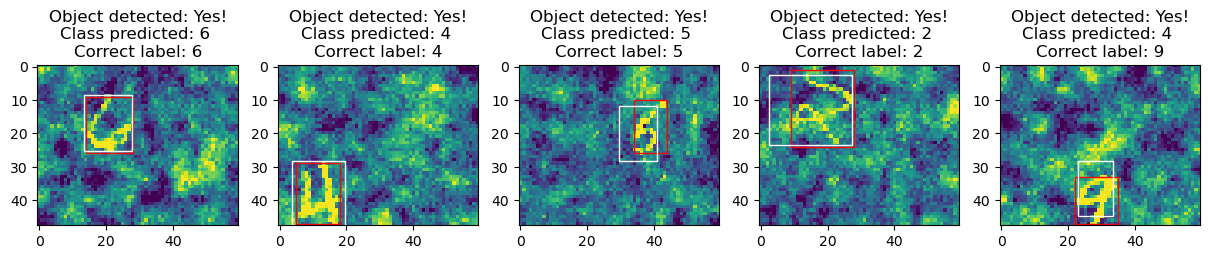

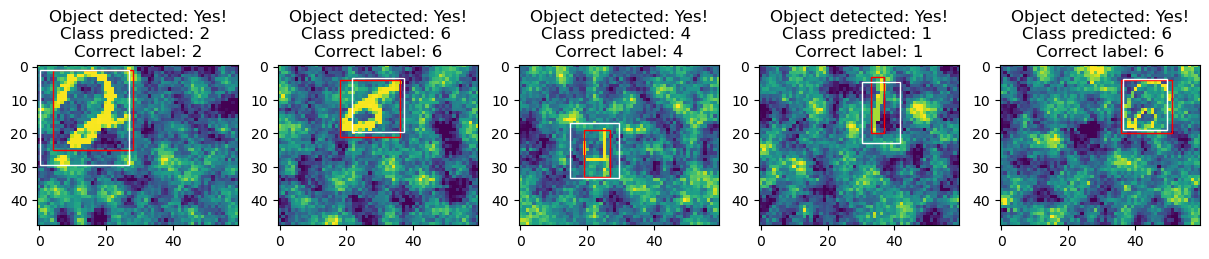

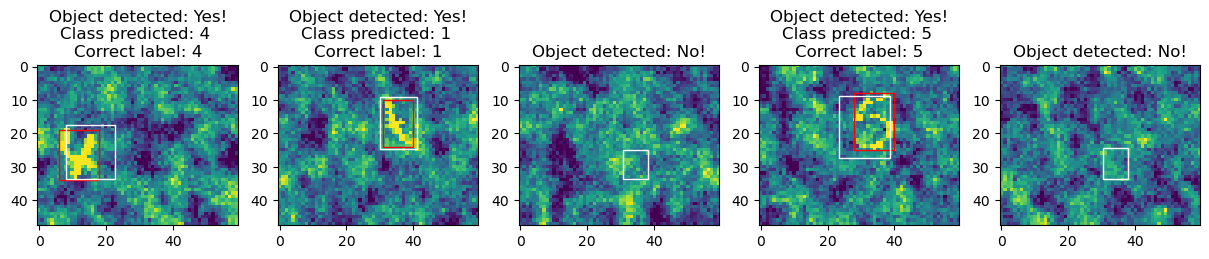

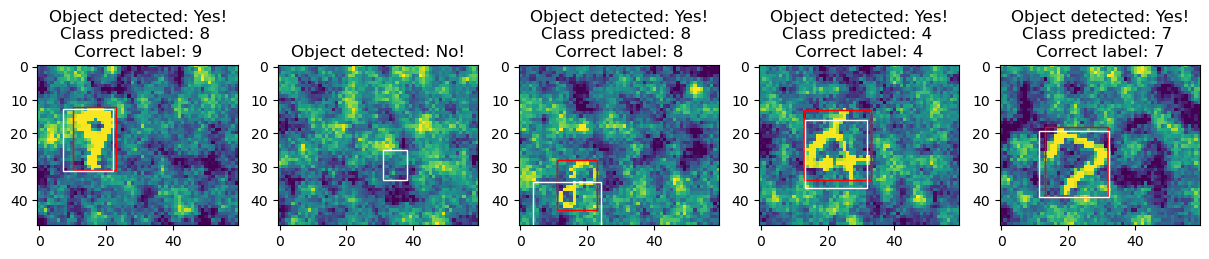

False

In [32]:
# Here we use shuffle = False
# Because it is easier to check the predictions made.
torch.manual_seed(265)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

def pred_subplots(model, loader, data):
    # Load the image from the tensorDataset
    model.eval()
    n = 0
    
    while True:
        
        with torch.no_grad():
            for imgs, labels in loader:
                                
                # We use torch.double to get the same results as Pytorch
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                outputs = model(imgs)

                #for i in range(10):
                fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

                for j, ax in enumerate(axes.flat):
                                    
                    n += 1

                    # Extract the x, y, w, and h values from the label
                    x, y, w, h = labels[j,1:5]
                    pred_object, x_pred, y_pred, w_pred, h_pred = outputs[j,0:5]
                    class_predicted = torch.argmax(outputs[j, 5:-1]).item()

                    # Calculate the top left and bottom right coordinates of the bounding box
                    image_height, image_width = imgs[0,0].shape
                    left = (x - w / 2) * image_width
                    top = (y - h / 2) * image_height
                    right = left + w * image_width
                    bottom = top + h * image_height

                    # Calculate the top left and bottom right coordinates of the bounding box
                    label_height, label_width = imgs[0,0].shape
                    left_pred = (x_pred - w_pred / 2) * label_width
                    top_pred = (y_pred - h_pred / 2) * label_height
                    right_pred = left_pred + w_pred * label_width
                    bottom_pred = top_pred + h_pred * label_height

                    # Create a Matplotlib figure and plot the image
                    ax.imshow(imgs[j,0])

                    # Create a Matplotlib rectangle object using the bounding box coordinates
                    rect_pred = plt.Rectangle((left, top), right - left, bottom - top, linewidth=1, edgecolor='r', facecolor='none')
                    rect_true = plt.Rectangle((left_pred, top_pred), 
                                            right_pred - left_pred, bottom_pred - top_pred, 
                                            linewidth=1, edgecolor='w', facecolor='none')

                    # Add the rectangle object to the plot
                    ax.add_patch(rect_pred)
                    ax.add_patch(rect_true)
                    
                    # Add heading stating if object has been predicted or not
                    if pred_object < 0:
                        ax.set_title("Object detected: No!")
                    else:
                        ax.set_title(f"Object detected: Yes!\n"
                                     "Class predicted: {} \n"
                                     "Correct label: {}".format(class_predicted, int(labels[j][-1])))

                # Show the plot
                plt.show()
                
                if n == 100:
                    return False
                

pred_subplots(model, train_loader, train_data)

# 5 Report (own PDF)